In [15]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch import optim

In [16]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# CNNモデルの定義
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 256)
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN()
print(model)

Using cpu device
CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [17]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [18]:
affine = T.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = T.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = T.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = T.ToTensor()

transform_train = T.Compose([affine, flip, to_tensor, normalize])
transform_test = T.Compose([to_tensor, normalize])

# 訓練データをdatasetsからダウンロード
training_data = datasets.CIFAR10(
    root="../data",
    train=True,
    download=True,
    transform=transform_train,
)

# テストデータをdatasetsからダウンロード
test_data = datasets.CIFAR10(
    root="../data",
    train=False,
    download=True,
    transform=transform_test,
)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
batch_size = 64

# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 32, 32])
Shape of y:  torch.Size([64]) torch.int64


In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

record_loss_train = []
record_loss_test = []

In [27]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [28]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [38]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 1.373267  [    0/50000]
loss: 1.150226  [ 6400/50000]
loss: 1.926339  [12800/50000]
loss: 1.246769  [19200/50000]
loss: 1.344657  [25600/50000]
loss: 1.308935  [32000/50000]
loss: 1.690694  [38400/50000]
loss: 1.491263  [44800/50000]
Test Error: 
 Accuracy: 65.0%, Avg loss: 0.015879 

Epoch 2
-------------------------------
loss: 0.900415  [    0/50000]
loss: 1.011433  [ 6400/50000]
loss: 0.997137  [12800/50000]
loss: 0.751366  [19200/50000]
loss: 1.002542  [25600/50000]
loss: 1.025754  [32000/50000]
loss: 0.827571  [38400/50000]
loss: 1.003816  [44800/50000]
Test Error: 
 Accuracy: 65.0%, Avg loss: 0.015889 

Epoch 3
-------------------------------
loss: 0.836682  [    0/50000]
loss: 1.092174  [ 6400/50000]
loss: 0.853075  [12800/50000]
loss: 0.924304  [19200/50000]
loss: 1.156164  [25600/50000]
loss: 1.028083  [32000/50000]
loss: 1.329787  [38400/50000]
loss: 1.158331  [44800/50000]
Test Error: 
 Accuracy: 65.0%, Avg loss: 0.015873 

Epoc

In [37]:
# モデルの保存
PATH = '../model/cnn_cifar.pth'
torch.save(model.state_dict(), PATH)

GroundTruth : Predicted
frog  : frog  o
bird  : bird  o
frog  : frog  o
frog  : frog  o
dog   : plane x
bird  : bird  o
dog   : dog   o
cat   : horse x
bird  : bird  o
dog   : cat   x
plane : plane o
bird  : horse x
truck : truck o
car   : car   o
car   : car   o
truck : truck o
bird  : deer  x
car   : car   o
car   : car   o
car   : plane x
car   : car   o
bird  : bird  o
bird  : dog   x
frog  : frog  o
plane : plane o
bird  : dog   x
cat   : frog  x
truck : truck o
ship  : truck x
bird  : horse x
bird  : bird  o
ship  : ship  o
truck : horse x
horse : horse o
horse : horse o
bird  : bird  o
deer  : deer  o
deer  : deer  o
dog   : dog   o
ship  : ship  o
truck : car   x
plane : plane o
plane : frog  x
horse : car   x
truck : truck o
dog   : cat   x
cat   : dog   x
plane : plane o
cat   : dog   x
car   : truck x
bird  : frog  x
ship  : ship  o
deer  : deer  o
dog   : dog   o
deer  : deer  o
frog  : frog  o
plane : plane o
dog   : cat   x
horse : frog  x
deer  : deer  o
deer  : deer  o


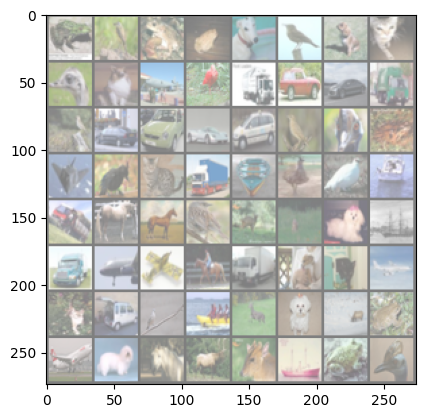

In [43]:
# テストデータでの評価
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

model = CNN()
# 保存した状態辞書をロード
model.load_state_dict(torch.load('../model/cnn_cifar.pth'))
model.eval()

# 画像の表示
def imshow(img):
    img = img / 2 + 0.5     # デノーマライズ
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.axis('off')  # 軸を非表示にする
    plt.show()

# 出力の表示
with torch.no_grad():
    outputs = model(images)
_, predicted = torch.max(outputs, 1)
print("GroundTruth : Predicted")
for j in range(batch_size):
    if classes[labels[j]] == classes[predicted[j]]:
        judge = "o"
    else:
        judge = "x"
    print("{} : {} {}".format(f'{classes[labels[j]]:5s}',f'{classes[predicted[j]]:5s}',judge))
    

    # print('GroundTruth:  ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    # print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

# 画像を表示
imshow(torchvision.utils.make_grid(images))